# DeepLabV3 Semantic Segmentation on EndoVis2017
**Task: Segment surgical instruments (10 classes + background)**

Classes:
- 0: Background
- 1: Bipolar Forceps
- 2: Prograsp Forceps
- 3: Large Needle Driver
- 4: Suction Instrument
- 5: Clip Applier
- 6: Monopolar
- 7: Curved Scissors
- 8: Ultrasound Probe
- 9: Vessel Sealer
- 10: Grasping Retractor

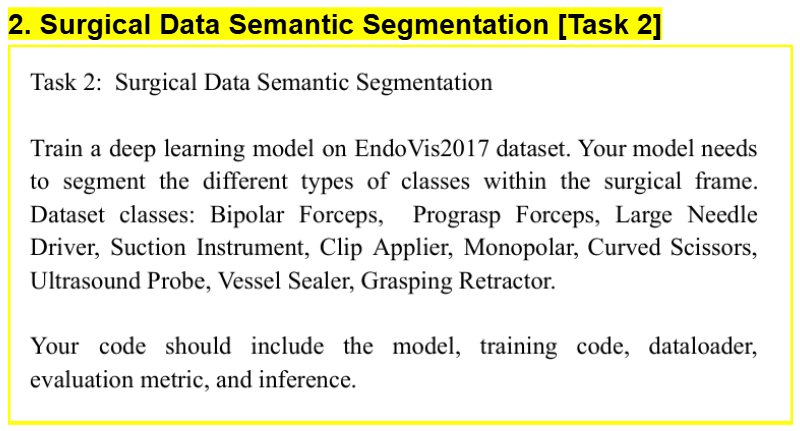

# In this experiment I tried to use DeepLabV3 as the semantic segmentation model, obtained 67% meanIOU on test set {Best case}
- Results decreased after augmentation on test set
- Looked up a method to improve our dataset {Future work: [Image synthesis approach] https://arxiv.org/pdf/2410.23962
- [Deeplab v3 paper] https://arxiv.org/pdf/1802.02611
- Looked up the difference between semantic, instance and panoptic segmentation

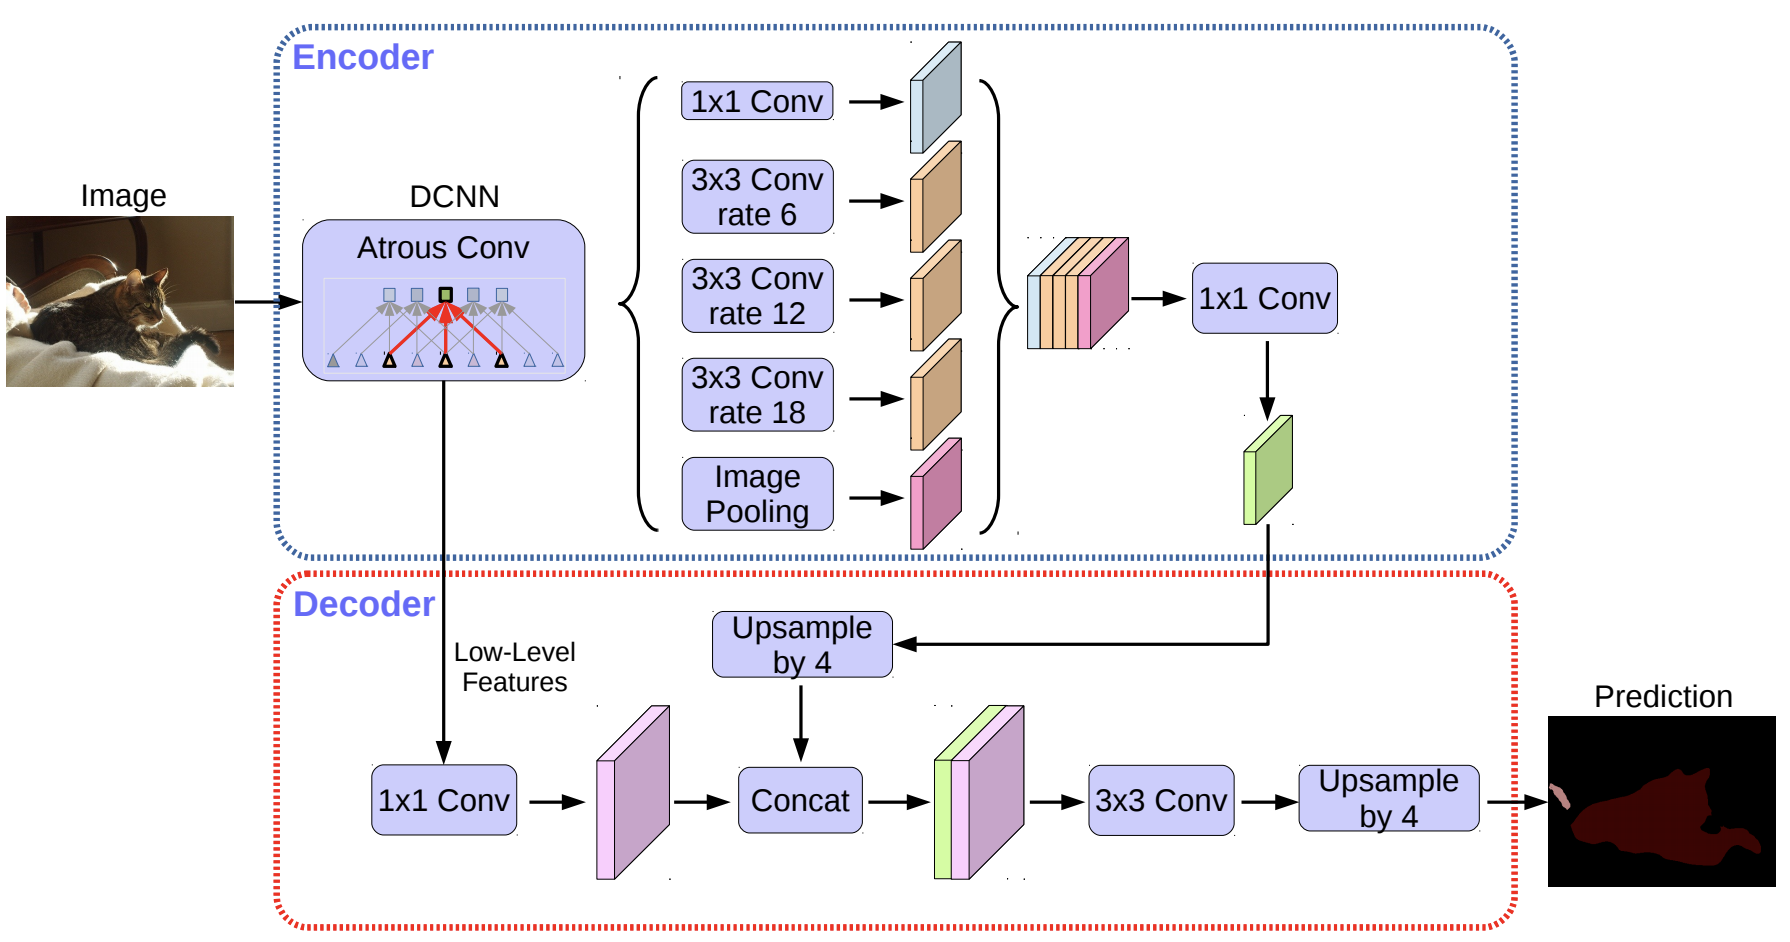

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files

# Upload your .zip file
uploaded = files.upload()


Saving endovis2017.zip to endovis2017.zip


In [ ]:
import zipfile
import os

# Find the uploaded ZIP file
zip_filename = list(uploaded.keys())[0]

# Create a target extraction directory
extract_dir = f"/content/{zip_filename.replace('.zip', '')}"
os.makedirs(extract_dir, exist_ok=True)

# Unzip it
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to: {extract_dir}")


Extracted to: /content/endovis2017


In [ ]:
!pip install torchvision

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = T.PILToTensor()(mask).squeeze(0)

        return image, mask.long()

In [ ]:
base_dir = '/content/endovis2017/endovis2017'
transform = T.Compose([
   T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_dataset = SegmentationDataset(f'{base_dir}/train/image', f'{base_dir}/train/label', transform=transform)
test_dataset = SegmentationDataset(f'{base_dir}/val1/image', f'{base_dir}/val1/label', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

In [ ]:
num_classes = 11
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 159MB/s]


In [ ]:
def train(model, loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, masks in loader:
            images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(loader):.4f}")

In [ ]:
def compute_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

In [ ]:
def test(model, loader):
    model.eval()
    iou_scores = []
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)
            iou = compute_iou(preds, masks, num_classes=11)
            iou_scores.append(iou)
    print(f"Mean IoU: {np.nanmean(iou_scores) * 100:.2f}%")

In [ ]:
train(model, train_loader, optimizer, criterion, epochs=10)
torch.save(model.state_dict(), 'deeplabv3_endovis.pth')
model.load_state_dict(torch.load('deeplabv3_endovis.pth'))
test(model, test_loader)

Epoch [1/10], Loss: 1.4374
Epoch [2/10], Loss: 0.6934
Epoch [3/10], Loss: 0.4083
Epoch [4/10], Loss: 0.2519
Epoch [5/10], Loss: 0.1886
Epoch [6/10], Loss: 0.1430
Epoch [7/10], Loss: 0.1056


In [ ]:
# Inference and Visualization
def visualize_prediction(image_tensor, mask_pred):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    image = (image * 255).astype('uint8')
    pred_mask = mask_pred.cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='jet')
    plt.axis('off')
    plt.show()


model.eval()
sample_image, _ = test_dataset[0]
with torch.no_grad():
    input_tensor = sample_image.unsqueeze(0).cuda()
    output = model(input_tensor)['out']
    pred_mask = torch.argmax(output.squeeze(), dim=0)

visualize_prediction(sample_image, pred_mask)

In [ ]:
 !pip install torchmetrics

# Here i was trying to implement meanIOU score across all classes

In [ ]:
!pip install torchmetrics

# ---------------- mean-IoU evaluation ----------------
import torch
from torchmetrics.classification import MulticlassJaccardIndex
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_classes = 10

metric = MulticlassJaccardIndex(num_classes=num_classes).to(device)
metric.reset()

model.eval()
with torch.no_grad():
    for images, masks in test_loader:

        images = images.to(device)

        masks = masks.to(device)

        logits = model(images)['out']
        preds = torch.argmax(logits, dim=1)


        metric.update(preds, masks)


class_iou = metric.compute()
mean_iou = class_iou.mean()

print("Class-wise IoU:", [f"{v:.4f}" for v in class_iou])
print(f"Mean IoU        : {mean_iou:.4f}")


In [ ]:

import pandas as pd
from IPython.display import display

class_names = [
    "Bipolar Forceps",
    "Prograsp Forceps",
    "Large Needle Driver",
    "Suction Instrument",
    "Clip Applier",
    "Monopolar",
    "Curved Scissors",
    "Ultrasound Probe",
    "Vessel Sealer",
    "Grasping Retractor"
]

iou_df = pd.DataFrame({
    "Class": class_names,
    "IoU": class_iou.cpu().numpy()
})


iou_df = iou_df.sort_values("Class").reset_index(drop=True)
display(iou_df)

print(f"Mean IoU      : {mean_iou:.4f}")

# Sample outputs from Experiments

Deep Lab v3 after Augmentation

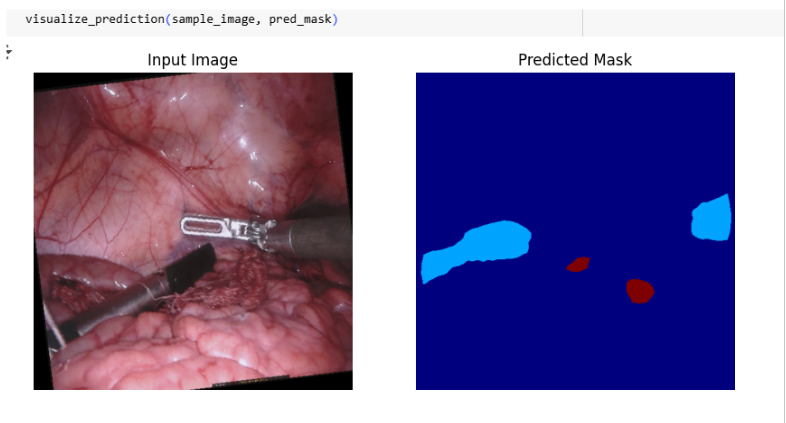

DeepLabV3 after No augmentation {Need to run again but this had the best case}

U-net - No Augmentation

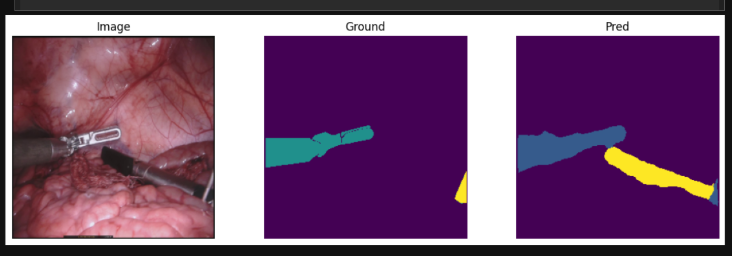